In [1]:
import sys
import json
import torch
import tensorboardX
import pandas as pd
from pathlib import Path
import plotly.express as px
from datetime import datetime
from typing import List, Iterator
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as tick


# import locals
sys.path.insert(0, str(Path('..').resolve()))
from tlaloc import EarningsGRUModel
from tlaloc import EarningsDataModule, SeqDataset

In [2]:
trnsf_path = Path('../outputs/model/params.json').resolve()
model_path = Path('../outputs/model/model.pth').resolve()

behind = 90
forward = 14

In [3]:
with open(trnsf_path, 'r') as f:
    meta = json.load(f)
print(json.dumps(meta, indent=4))

{
    "model": {
        "input_dim": 1,
        "hidden_dim": 32,
        "num_layers": 2,
        "output_dim": 1,
        "lr": 0.01
    },
    "data": {
        "min": 271671.588898111,
        "max": 524105.5617281316,
        "window": 100
    }
}


In [4]:
model = EarningsGRUModel(**meta['model'])
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
filepath = 'model.onnx'
input_sample = torch.zeros((1, 100, 1))
model.to_onnx(filepath, input_sample, export_params=True)

C:\Users\sethj\.conda\envs\torch\lib\site-packages\torch\onnx\symbolic_opset9.py:1941: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn("Exporting a model to ONNX with a batch_size other than 1, " +


In [6]:
data = EarningsDataModule.load('../data/earnings.parquet')
data = data['earnings'].values
seq = torch.FloatTensor(data[int(-behind*1.5):])
seq_adj = SeqDataset.scale(seq, meta['data']['min'], meta['data']['max'])
print(repr(seq.numpy()))


array([330429.34, 335124.1 , 337927.4 , 337882.78, 340398.47, 348004.94,
       351887.16, 353909.22, 349526.72, 357322.5 , 360355.3 , 357960.47,
       353047.97, 360072.47, 358046.12, 354156.03, 352541.2 , 355159.06,
       357326.4 , 359204.56, 354851.44, 345909.5 , 344326.1 , 345570.56,
       344388.5 , 346549.12, 344628.03, 345876.88, 342719.56, 338990.  ,
       345393.6 , 346861.25, 350205.9 , 351335.66, 349425.16, 354068.47,
       353115.  , 352033.  , 355203.28, 354767.22, 347558.28, 349151.47,
       348895.66, 345206.62, 342617.56, 344604.34, 349649.1 , 345719.28,
       348129.8 , 352518.56, 352416.53, 354929.84, 349414.72, 348425.  ,
       351704.2 , 351390.56, 344502.47, 336911.22, 333464.03, 330384.1 ,
       329339.9 , 333387.9 , 333351.94, 333792.2 , 333526.6 , 331457.75,
       334915.47, 335476.75, 339905.9 , 336842.47, 335527.6 , 337232.53,
       336993.06, 338816.78, 332234.88, 335720.66, 336146.9 , 341194.94,
       342124.25, 343852.38, 343336.38, 344777.4 , 

NameError: name 'df' is not defined

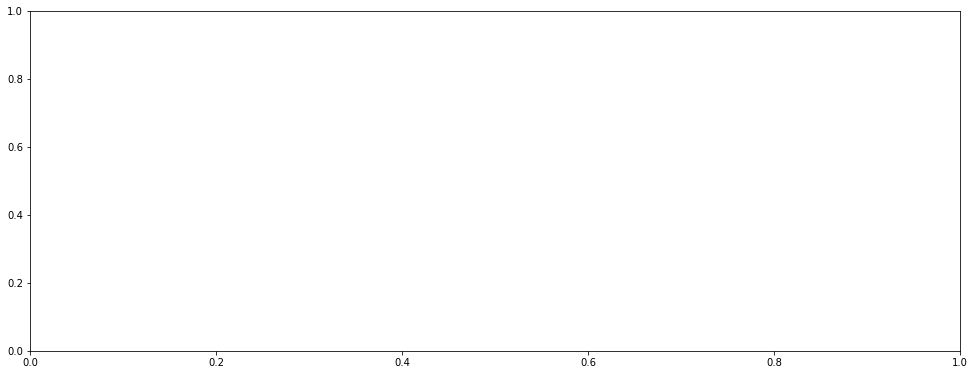

In [7]:
dataframe = pd.read_parquet('../data/earnings.parquet')
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)

ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()

In [ ]:
df2 = df.groupby('date')['earnings'].sum().reset_index(name='earnings')
print(df2)

#fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
#ax.plot(df2['date'], df2['earnings'], color='blue', label='actual')
#ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
#leg = ax.legend()
#plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
#plt.xlabel('Period')
#plt.ylabel('Earnings')
#plt.show()


In [ ]:


for key, grp in df.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)

ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()

fig = px.line(df2, y="earnings")
fig.update_layout(title=f'Sum', xaxis_title='date', yaxis_title='earnings', width=960)
fig.show()

In [ ]:
df3 = df2['earnings'].values

In [ ]:
fig = px.line(df3, y=0)
fig.update_layout(title=f'Sum', xaxis_title='date', yaxis_title='earnings', width=960)
fig.show()

In [ ]:
#import torch, gc
#gc.collect()
#torch.cuda.empty_cache()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
import numpy as np
seq_test = torch.FloatTensor(np.array([i for i in range(10)]))
print(seq_test)
win, lookahead = 3, 4

overlap = []
for i in reversed(range(1, lookahead+1)):
    print(i, seq_test[-win-i:-i])
    overlap.append(float(i))

print('overlap:', overlap)

test_inputs = list(seq_test[-win:].numpy())
print('prediction:', test_inputs)
for i in range(lookahead):
    print(i, test_inputs[-win:])
    test_inputs.append(float(i))

print(test_inputs)
print(test_inputs[-lookahead:])


In [ ]:

def predict(seq: torch.Tensor, window: int, lookbehind: int, lookahead: int) -> List:
    overlap = []
    predixn = list(seq[-window:].numpy())
    with torch.no_grad():
        model.to(device)
        model.eval()
        # get previous lookahead period (overlap)
        for i in reversed(range(1, lookbehind+1)):
            x = torch.FloatTensor(seq[-window-i:-i]).view(1, -1)
            y = model(x.to(device))
            overlap.append(y.detach().cpu().item())

        # begin future lookahead period (predictions)
        for i in range(lookahead):
            x = torch.FloatTensor(predixn[-window:]).view(1, -1)
            y = model(x.to(device))
            predixn.append(y.detach().cpu().item())

    return overlap + predixn[-lookahead:]

In [ ]:
#p_seq = predict(seq_adj, meta['data']['window'], behind, forward)
p_seq = model.predict(list(seq_adj.numpy()), meta['data']['window'], behind, forward)

In [ ]:
dmin, dmax = meta['data']['min'], meta['data']['max']
actual = SeqDataset.inverse_scale(seq_adj, dmin, dmax)
predicted = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), dmin, dmax)


seq_size = seq_adj.size(0)
actual_range = [i for i in range(seq_size)]
pr = (seq_size-behind-1,seq_size+forward-1)
pred_range = [i for i in range(pr[0], pr[1])]
print(f'bd/fwd:        {behind}/{forward}')
print(f'seq sz:        {seq_size}')
print(f'seq range:     {range(seq_size)}, max: {actual_range[-1]}')
print(f'pred sz:       {predicted.size(0)}')
print(f'pred range:    {range(pr[0], pr[1])}, max: {pred_range[-1]}, min: {pred_range[0]}')
print(f'pred range sz: {pr[1] - pr[0]}')



In [ ]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=actual_range, y=actual.numpy(), mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=pred_range, y=predicted.numpy(), mode='lines', name='Prediction'))
fig.update_layout(title=f'Earnings Prediction',
                   xaxis_title='Day',
                   yaxis_title='Scaled Price', width=960)
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick

seq_size = seq_adj.size(0)
actual_range = [i for i in range(seq_size)]
pred_range = [i for i in range(seq_size-behind,seq_size+forward)]

dmin, dmax = meta['data']['min'], meta['data']['max']
actual = SeqDataset.inverse_scale(seq_adj, dmin, dmax)
predicted = SeqDataset.inverse_scale(torch.FloatTensor(p_seq), dmin, dmax)

fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax.plot(actual_range, actual, color='blue', label='actual')
ax.plot(pred_range, predicted, color='red', label='predictions')
ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x, p: '${:1.0f}K'.format(x/1000.)))
leg = ax.legend()
plt.title(f'Sequence Prediction [Back: {behind}, Forward: {forward}]')
plt.xlabel('Period')
plt.ylabel('Earnings')
plt.show()
